<a href="https://colab.research.google.com/github/yamna20/CERN-COLLISION-DATA/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# This is the size of our encoded representations
digit_size = 28        # number of pixels in x or y direction in the images
original_dim = digit_size * digit_size # dimensionality of 784
encoding_dim = 32  # 32 floats -> compression of factor 24.5,
                   # assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(original_dim,))

# several options for configuring the autoencoder/decoder:
# Choose from:
# "simple" (single dense layer),
# "sparce" (with additional sparcity constraint),
# "multilayer" (multiple dense layers),
# "convolutional" (convolutional NN),
# "variational" (variational autoencoder)
option = "simple"

noise = "off"   # do you want to add noise to the training images - off/on
noise_factor = 0.5   # how much Gaussian noise do you want to add
                     # (try 0.5, 0.25, 1.0 and look at the accuracy and images)
nepochs = 20    # play around with the number of training steps
batch_size = 64 # play around with the number of samples per gradient update

In [ ]:
if "simple" in option:  # simple single dense layer autoencoder
#simplest autoencoder default with a sinlge dense layer

# "encoded" is the encoded representation of the input
  encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(original_dim, activation='sigmoid')(encoded)
elif "sparce" in option:   # same, but with sparcity constraint
  from keras import regularizers

# Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
  decoded = layers.Dense(original_dim, activation='sigmoid')(encoded)
elif "multi" in option:
  encoded = layers.Dense(128, activation='relu')(input_img)
  encoded = layers.Dense(64, activation='relu')(encoded)
  encoded = layers.Dense(32, activation='relu')(encoded)

  decoded = layers.Dense(64, activation='relu')(encoded)
  decoded = layers.Dense(128, activation='relu')(decoded)
  decoded = layers.Dense(original_dim, activation='sigmoid')(decoded)
elif "conv" in option: # convolutional autoencoder
  input_img = keras.Input(shape=(28, 28, 1))

  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
elif "var" in option:    # variational autoencoder
  intermediate_dim = 64
  latent_dim = 2

  h = layers.Dense(intermediate_dim, activation='relu')(input_img)
  z_mean = layers.Dense(latent_dim)(h)
  z_log_sigma = layers.Dense(latent_dim)(h)
else:
  print("Unknown option")

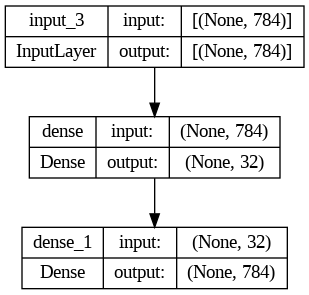

In [ ]:
# This model maps an input to its reconstruction
if "var" in option:   # this is what we do for the variational autoecoder
  from keras import backend as K
# Define a sampling function to be used later to sample the latent space
  def sampling(args):
      z_mean, z_log_sigma = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=0.1)
      return z_mean + K.exp(z_log_sigma) * epsilon

  z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
  encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
  latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
  x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = layers.Dense(original_dim, activation='sigmoid')(x)
  decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
  outputs = decoder(encoder(input_img)[2])
  autoencoder = keras.Model(input_img, outputs, name='vae_mlp')
# Calculate the reconstruction loss using cross-entropy
  reconstruction_loss = keras.losses.binary_crossentropy(input_img, outputs)
  reconstruction_loss *= original_dim
# Add the KL divergence term to the loss function
  kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
# Pass this custom loss function to the autoencoder
  autoencoder.add_loss(vae_loss)
# Compile the autoencoder
  autoencoder.compile(optimizer='adam',metrics=['accuracy'])
else:   # and this is what we do for regular autoencoders
  autoencoder = keras.Model(input_img, decoded)
# This model maps an input to its encoded representation
  encoder = keras.Model(input_img, encoded)
# Compile the autoencoder
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Display the schematics of the autoencoder
keras.utils.plot_model(autoencoder, show_shapes = True)

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
if "conv" in option:
  x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
  x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
else:
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

if "on" in noise:
  x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

  x_train_noisy = np.clip(x_train_noisy, 0., 1.)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)
else:
  x_train_noisy = x_train
  x_test_noisy = x_test


11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [ ]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=nepochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/20
938/938 [==============================] - 9s 5ms/step - loss: 0.1908 - accuracy: 0.0103 - val_loss: 0.1326 - val_accuracy: 0.0111
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1180 - accuracy: 0.0102 - val_loss: 0.1055 - val_accuracy: 0.0108
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.1021 - accuracy: 0.0112 - val_loss: 0.0974 - val_accuracy: 0.0117
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0972 - accuracy: 0.0112 - val_loss: 0.0948 - val_accuracy: 0.0117
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0956 - accuracy: 0.0113 - val_loss: 0.0937 - val_accuracy: 0.0127
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0949 - accuracy: 0.0111 - val_loss: 0.0934 - val_accuracy: 0.0124
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0945 - accuracy: 0.0108 - val_loss: 0.0931 - val_accuracy: 0.0106
Epoch 

In [ ]:
#encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
if "var" in option:
  x_test_encoded = np.array(encoder.predict(x_test,batch_size = 32))
  plt.figure(figsize=(6, 6))
  col = np.array(y_test).astype(int)
  plt.scatter(x_test_encoded[0,:,0], x_test_encoded[0,:,1], c=col, s=0.2, cmap='hsv')
  plt.colorbar()
  plt.show()

In [ ]:
if "var" in option: # Display a 2D manifold of the digits by using a grid in
                    # the latent space and generating images
                    # Does the figure match the latent space figure above?
  npoints = 12  # figure with npoints x npoints digits

  figure = np.zeros((digit_size * npoints, digit_size * npoints))
  # We will sample npoints points within [-4, 4] standard deviations
  grid_x = np.linspace(-4, 4, npoints)
  grid_y = np.linspace(-4, 4, npoints)

  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample,verbose=0)
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(8, 8))
  plt.imshow(figure, origin='upper',extent=[-4, 4, 4, -4])# note that y axis
                                                          # is reversed
  plt.show()